You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

In [1]:
import sys
import warnings

warnings.filterwarnings('ignore')

COLAB_RUNTIME = 'google.colab' in sys.modules
if COLAB_RUNTIME:
    !git config --global init.defaultBranch main
    !git init
    !git remote add origin https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !git pull origin main
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] updating v1.12.0 -> v1.12.1
pre-commit installed at .git/hooks/pre-commit


Loading the configuration

In [1]:
from src.utils import load_config
import os

config_path = os.path.join("config","config.yaml")
config = load_config(config_path)

---

Loading the dataset

In [5]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info

data = VesselDataModule(config.dataset)
labels = data.data
#data_info(data)

Train size: 2999
Val size: 599
Test size: 401


AttributeError: 'int' object has no attribute 'value'

Data distribution

[0 0 0 ... 1 1 1]


<Axes: xlabel='label', ylabel='count'>

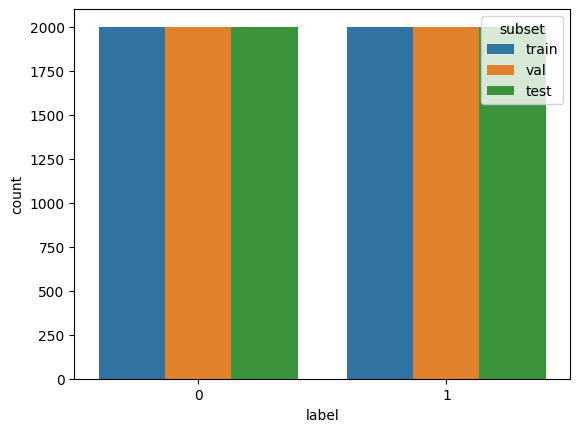

In [18]:
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming labels are numpy arrays for each subset
train_labels = data.train_set.dataset.labels.numpy()
val_labels = data.val_set.dataset.labels.numpy()
test_labels = data.test_set.dataset.labels.numpy()

print(test_labels)

# Combine labels into a single array and create corresponding subset identifiers
combined_labels = np.concatenate([train_labels, val_labels, test_labels])
subsets = ['train'] * len(train_labels) + ['val'] * len(val_labels) + ['test'] * len(test_labels)

# Create a DataFrame for seaborn plotting
df = pd.DataFrame({'label': combined_labels, 'subset': subsets})

# Plot with seaborn, differentiating subsets with hue
sns.countplot(x='label', hue='subset', data=df)

In [ ]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

Performing equivariance check

In [ ]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()

batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10]
TestEquivariance.INPUT_DATA = batch

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)

---

Baseline

In [ ]:
from src.models import BaselineTransformer
from src.utils.hpo import baseline_hpo

baseline_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

In [3]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

model = BaselineTransformer(config.baseline)
trainer = VesselTrainer(config.trainer)
trainer.fit(model, data)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: neverorfrog (neverorfrog-sapienza). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/daniaffch/.netrc


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | encoder        | TransformerEncoder | 2.2 K  | train
1 | embedder       | Linear             | 272    | train
2 | projecti

Epoch 0: 100%|██████████| 750/750 [00:13<00:00, 57.14it/s, v_num=yxek, val/loss=0.267, val/acc=0.883, val/f1=0.938, train/loss=0.188, train/acc=0.925, train/f1=0.886]

Metric val/loss improved. New best score: 0.267
Epoch 0, global step 750: 'val/loss' reached 0.26699 (best 0.26699), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=0-step=750-v1.ckpt' as top 1


Epoch 1: 100%|██████████| 750/750 [00:13<00:00, 56.39it/s, v_num=yxek, val/loss=0.0505, val/acc=0.985, val/f1=0.992, train/loss=0.0771, train/acc=0.974, train/f1=0.961]

Metric val/loss improved by 0.217 >= min_delta = 1e-05. New best score: 0.050
Epoch 1, global step 1500: 'val/loss' reached 0.05046 (best 0.05046), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=1-step=1500.ckpt' as top 1


Epoch 2: 100%|██████████| 750/750 [00:13<00:00, 57.28it/s, v_num=yxek, val/loss=0.0562, val/acc=0.985, val/f1=0.992, train/loss=0.0644, train/acc=0.976, train/f1=0.964]

Epoch 2, global step 2250: 'val/loss' was not in top 1


Epoch 3: 100%|██████████| 750/750 [00:13<00:00, 56.71it/s, v_num=yxek, val/loss=0.00739, val/acc=1.000, val/f1=1.000, train/loss=0.0434, train/acc=0.981, train/f1=0.972]

Metric val/loss improved by 0.043 >= min_delta = 1e-05. New best score: 0.007
Epoch 3, global step 3000: 'val/loss' reached 0.00739 (best 0.00739), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=3-step=3000.ckpt' as top 1


Epoch 4: 100%|██████████| 750/750 [00:13<00:00, 56.00it/s, v_num=yxek, val/loss=0.00081, val/acc=1.000, val/f1=1.000, train/loss=0.028, train/acc=0.991, train/f1=0.987] 

Metric val/loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.001
Epoch 4, global step 3750: 'val/loss' reached 0.00081 (best 0.00081), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=4-step=3750.ckpt' as top 1


Epoch 5: 100%|██████████| 750/750 [00:14<00:00, 51.59it/s, v_num=yxek, val/loss=0.00859, val/acc=0.998, val/f1=0.999, train/loss=0.0147, train/acc=0.994, train/f1=0.992]

Epoch 5, global step 4500: 'val/loss' was not in top 1


Epoch 6: 100%|██████████| 750/750 [00:13<00:00, 54.50it/s, v_num=yxek, val/loss=0.00756, val/acc=0.997, val/f1=0.998, train/loss=0.0246, train/acc=0.993, train/f1=0.989]

Epoch 6, global step 5250: 'val/loss' was not in top 1


Epoch 7: 100%|██████████| 750/750 [00:13<00:00, 53.66it/s, v_num=yxek, val/loss=0.000591, val/acc=1.000, val/f1=1.000, train/loss=0.00452, train/acc=0.999, train/f1=0.998]

Metric val/loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.001
Epoch 7, global step 6000: 'val/loss' reached 0.00059 (best 0.00059), saving model to '/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000.ckpt' as top 1


Epoch 8: 100%|██████████| 750/750 [00:13<00:00, 55.33it/s, v_num=yxek, val/loss=0.00167, val/acc=1.000, val/f1=1.000, train/loss=0.00126, train/acc=1.000, train/f1=1.000] 

Epoch 8, global step 6750: 'val/loss' was not in top 1


Epoch 9: 100%|██████████| 750/750 [00:17<00:00, 43.67it/s, v_num=yxek, val/loss=0.000814, val/acc=1.000, val/f1=1.000, train/loss=0.00303, train/acc=0.999, train/f1=0.999]

Epoch 9, global step 7500: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:14<00:00, 50.09it/s, v_num=yxek, val/loss=0.212, val/acc=0.913, val/f1=0.955, train/loss=0.00349, train/acc=0.999, train/f1=0.999]   

Monitored metric val/loss did not improve in the last 3 records. Best score: 0.001. Signaling Trainer to stop.
Epoch 10, global step 8250: 'val/loss' was not in top 1


Epoch 10: 100%|██████████| 750/750 [00:14<00:00, 50.07it/s, v_num=yxek, val/loss=0.212, val/acc=0.913, val/f1=0.955, train/loss=0.00349, train/acc=0.999, train/f1=0.999]


Restoring states from the checkpoint path at /home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/ckpt/epoch=7-step=6000.ckpt
/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case whe

Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 84.68it/s]tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True,

/home/daniaffch/Uni/Deep_Learning/Vessel-Geometric-Transformers/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


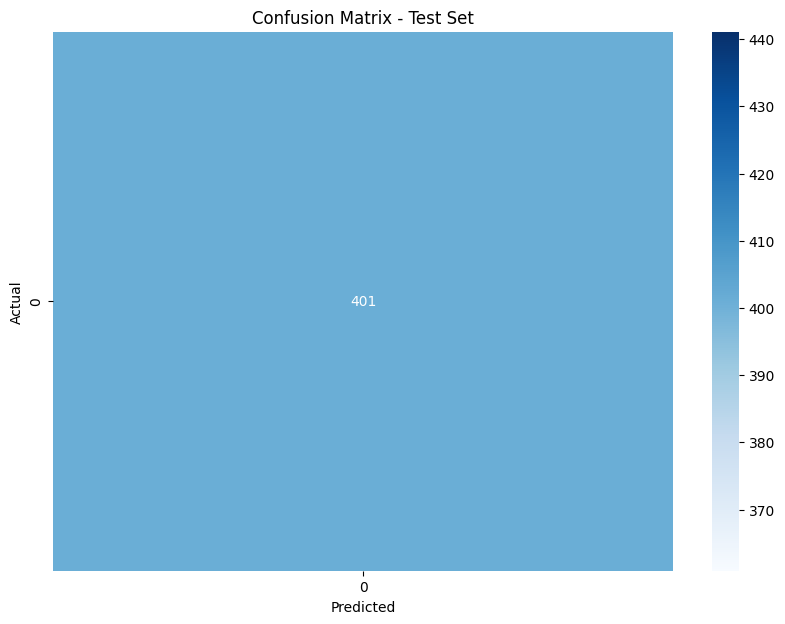

Testing DataLoader 0: 100%|██████████| 101/101 [00:01<00:00, 66.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │            1.0            │
│          test/f1          │            1.0            │
│         test/loss         │  0.00014891338651068509   │
└───────────────────────────┴───────────────────────────┘

In [4]:
trainer.test(model, data)

---

Gatr

In [ ]:
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer

model = Gatr(config.gatr)
trainer = VesselTrainer(config.trainer)
trainer.fit(model, data)

In [9]:
trainer.test(model, data)

----